In [12]:
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
DATA_PATH ='D:/amityu/backoffice_data/'
#movie = 'Control'
#movie ='140721'
#movie ='150721'
#movie ='100621'
#movie = '130721_CCA60_RAW'
#movie ='280523 AM100 568_1'
movie = 'control_1_050721'
#movie = 'cca120'
#movie = 'cca120_am200'
MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
ADD_DATA_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/add_data/%s/'%movie
import pandas as pd
import importlib
from matplotlib.cm import ScalarMappable
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import  utils.graph_utils as gu
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import warnings
from tqdm.notebook import tqdm
import os
mu_symbol = "\u03BC"

In [14]:
surface = np.load(MOVIE_PATH + 'np/height.npy', mmap_mode='r')
membrane = np.load(MOVIE_PATH + 'np/membrane.npy', mmap_mode='r')
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy', mmap_mode='r')
#channel2 = np.load(MOVIE_PATH + 'np/motors_norm.npy', mmap_mode='r')
time_df = pd.read_csv(ADD_DATA_PATH + '%s_time.csv'%movie)
#motors = np.load(MOVIE_PATH + 'np/motors_norm.npy', mmap_mode='r')

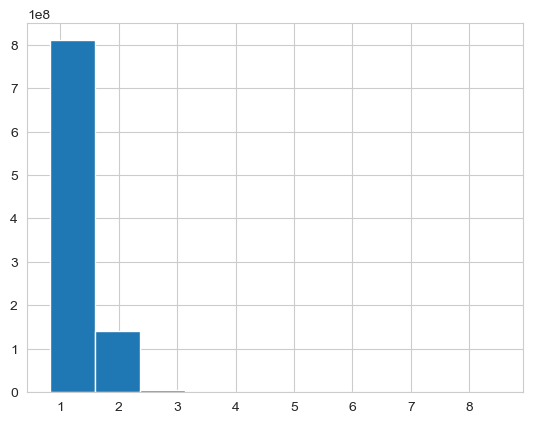

In [4]:
plt.hist(gel.flatten())
plt.show()

In [7]:
np.percentile(gel[~np.isnan(gel)], 99.8)

2.8446174695786994

In [18]:

# Replace zeros with NaNs in channel2
channel2 = np.where(channel2==0, np.nan, channel2)

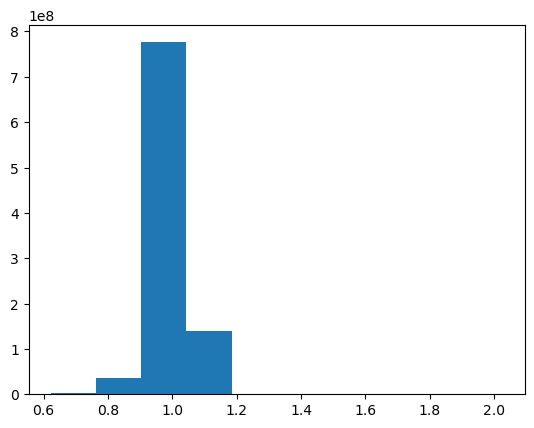

In [106]:
plt.hist(channel2.flatten())
plt.show()

         

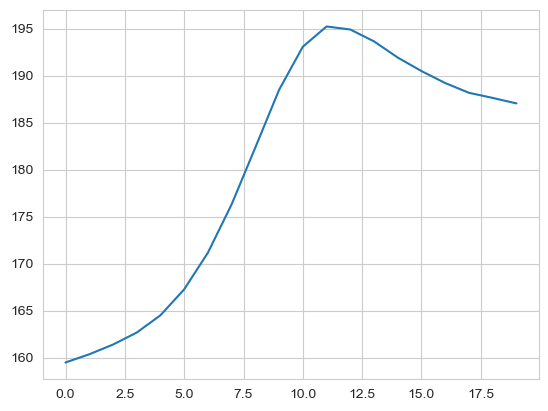

In [22]:
plt.plot(np.nanmean(channel2[:, :20, 200, :], axis=(0, 2)))
plt.show()

In [16]:
np.percentile(channel2[~np.isnan(channel2)], 99.8)

210.9366455078125

In [3]:
def my_normalize(x):
    return (x - np.nanmin(  x))/(np.nanmax(x) - np.nanmin(x))


## <span color='red'> trim files, add vertical line, add spike

In [116]:
# replace surface with spike if needed

spike_time_range = range(23,30)
spike = np.load(MOVIE_PATH + 'np/spike.npy')
surface = np.load(MOVIE_PATH + 'np/height.npy')
surface[spike_time_range] = spike[spike_time_range]
time_df = pd.read_csv(ADD_DATA_PATH + '%s_time.csv'%movie)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/amityu/Gel_Sheet_Data/280523 AM100 568_1/np/spike.npy'

In [4]:
first_trim = True
if first_trim:
    trim_img_from_in_x = 80
    gel = gel[:, :, :, trim_img_from_in_x:]
    membrane = membrane[:, :, trim_img_from_in_x:]
    surface = surface[:, :, trim_img_from_in_x:]

In [5]:
channel2 = channel2[:, :, :, trim_img_from_in_x:]

In [6]:
#enlarge gel and membrane in z axis, to enlarge the image
gel = np.concatenate((gel, np.zeros(shape=(gel.shape[0], 30, gel.shape[2], gel.shape[3]))), axis=1)
channel2 = np.concatenate((channel2, np.zeros(shape=(channel2.shape[0], 30, channel2.shape[2], channel2.shape[3]))), axis=1)
gel[gel == 0] = np.nan
channel2[channel2 == 0] = np.nan

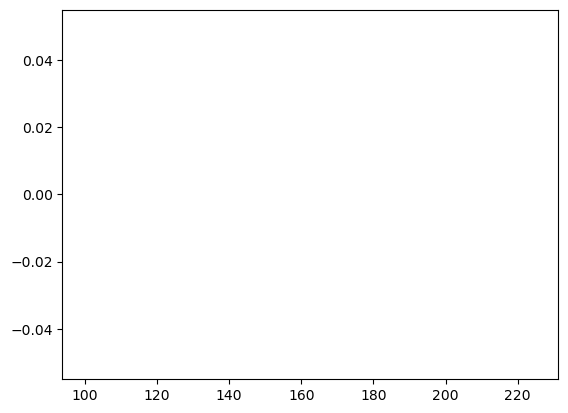

In [120]:
# histogram to decide on vmin of the membrane in imshow
plt.hist(channel2.flatten(), bins = np.arange(100, 230, 5))
plt.show()

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6826: RuntimeWarning: All-NaN axis encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: All-NaN axis encountered
  xmax = max(xmax, np.nanmax(xi))


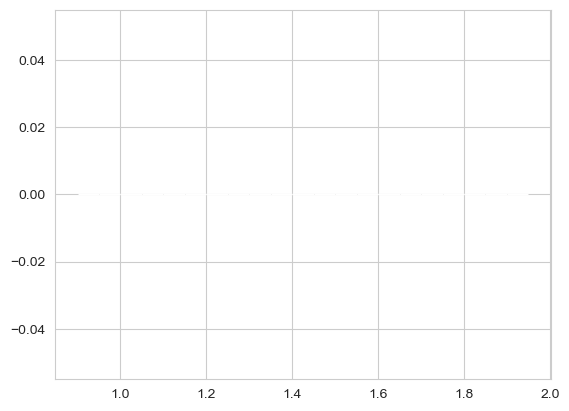

In [11]:
plt.hist(gel[:,:,y,:].flatten(), bins = np.arange(0.9,2,0.05))
plt.show()

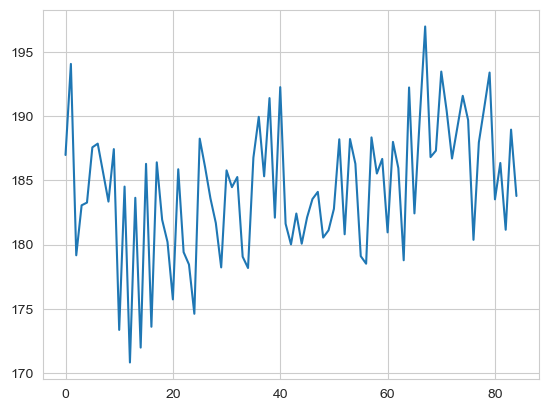

In [24]:
plt.plot(channel2[:, 25, y, 100])
plt.show()


## <span color='red'> Side view + segmentation animation ver1

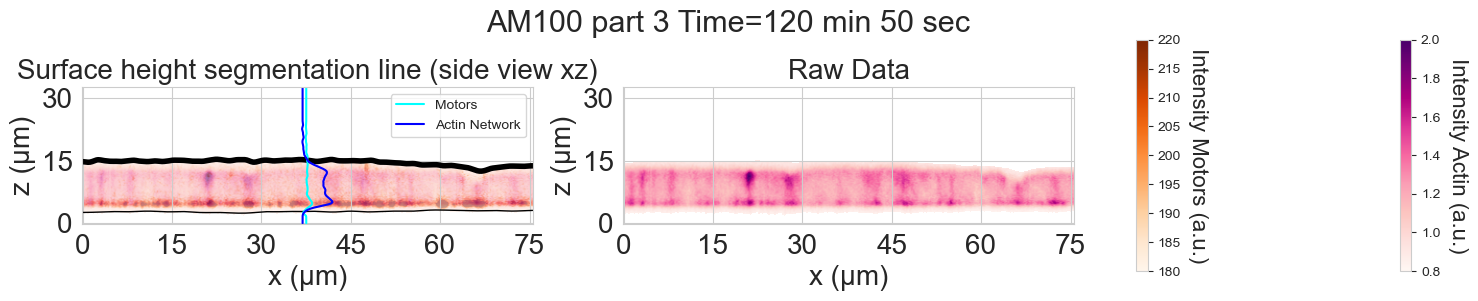

In [11]:
# Animation parameters
pixel_size_x = 0.175 
pixel_size_z = 0.250
vmin = 0.8
vmax = 2
vmin_membrane = 180
vmax_membrane = 220 
z1 = 0
z2 = gel.shape[1]
y = 100
plot_sigma = 3
color_map = 'RdPu'
color_map_membrane = 'Oranges'    
alpha_membrane = 0.4
alpha_gel = 0.9
movie_name = 'AM100 part 3'
channel_2_label = 'Motors' #'SLB'
membrane_plot_sigma = 7
draw_segmentation_line = True
plot_line_scan_gel = True
plot_line_scan_membrane = True
cut_membrane_to_the_top = False
save_images = True
# --- frames replaced with spike 19-24
frames_per_sec = 4
#t_values = np.concatenate((np.arange(0,  19,1/frames_per_sec),np.arange(20,  28,1/frames_per_sec), np.arange(30,len(gel),1/frames_per_sec)), axis = 0)  # Replace start_t and end_t with your desired range
t_values= np.arange(0, len(gel), 1/frames_per_sec)
mu_symbol = "\u03BC"


# Create the figure and axis

norm = Normalize(vmin=vmin, vmax=vmax)
fig, axes  = plt.subplots(1, 2, figsize=(20, 3))
(ax1,ax2) = axes
mappable = ScalarMappable(norm=norm, cmap=color_map)
mappable.set_array(gel[:, :, y, :])

cbar = plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=1)
cbar.set_label('Intensity Actin (a.u.)', rotation=270, fontsize = 16, labelpad = 20)

norm_ch2 = Normalize(vmin=vmin_membrane, vmax=vmax_membrane)
mappable_ch2 = ScalarMappable(norm=norm_ch2, cmap=color_map_membrane)
mappable_ch2.set_array(channel2[:, :, y, :])

cbar_ch2 = plt.colorbar(mappable_ch2, ax=axes.ravel().tolist(), shrink=1)
cbar_ch2.set_label('Intensity Motors (a.u.)', rotation=270, fontsize = 16, labelpad = 20)


# Create a function to update the plot for each t value
def update(t):
    ax1.clear()
    ax2.clear()
    xtick_labels = np.arange(0, gel.shape[3]* pixel_size_x, 15).astype(int)
    xticks = np.arange(0, gel.shape[3], 15/ pixel_size_x).astype(int)
    ytick_labels = np.arange(0, gel.shape[1]* pixel_size_z, 15).astype(int)
    yticks = np.arange(0, gel.shape[1], 15/ pixel_size_z).astype(int)

    t = int(t)
    
    #   Raw Data  image ax2
    img_gel = gel[t, :, y, :].copy()[:,:]
   
    #gel segmentation line
    h = surface[t][:,:]
    try:
        segmentation_line = gu.interpolate_smooth_restore_1d(h[y, :], plot_sigma)
    except:
        print ('error in interpolation, caused by spike t= %d'%t)
        return
    border_line = gu.interp_1d(segmentation_line)
    membrane_segmentation_line = gu.interpolate_smooth_restore_1d(membrane[t, y, :], membrane_plot_sigma)
    membrane_border_line = gu.interp_1d(membrane_segmentation_line)
    
    for i in range(len(border_line)):
        img_gel[int(border_line[i]+1):, i] = np.nan
        if np.isnan(membrane[t, y, i]):
        
            img_gel[:, i] = np.nan
        else:
            img_gel[:max(1,int(membrane[t, y, i]))-1, i] = np.nan


    ax1.imshow(img_gel, origin='lower', cmap=color_map, alpha=alpha_gel)
    
    ax1.set_xlabel('x (%sm)' % mu_symbol, fontsize = 20)
    ax1.set_xticks(xticks, xtick_labels, fontsize = 20)
    ax1.set_ylabel('z (%sm)' % mu_symbol, fontsize = 20)
    ax1.set_yticks(yticks, ytick_labels, fontsize = 20)
       
    if draw_segmentation_line:
        ax1.plot(segmentation_line, 'black', lw=4, linestyle='-')
        ax1.plot(membrane_segmentation_line, 'black', lw=1, linestyle='-')
    
    ax1.set_title('Surface height segmentation line (side view xz)', fontsize = 20)
    
    #plot membrane intensity
    if plot_line_scan_membrane:
        img_membrane = channel2[t, :, y, :].copy()
        
        for i in range(len(border_line)):
            img_membrane[int(border_line[i]+1):, i] = np.nan
            if cut_membrane_to_the_top:
                img_membrane[int(membrane_border_line[i]+12):, i] = np.nan
            if np.isnan(membrane[t, y, i]):
                img_membrane[:, i] = np.nan
            else:
                img_membrane[:max(1,int(membrane[t, y, i])-1), i] = np.nan
    
        ax1.imshow(img_membrane, origin='lower', cmap=color_map_membrane, alpha=alpha_membrane, vmin = vmin_membrane, vmax = vmax_membrane)
    

# ---------------- plot membrane and gel intensity line scan
  
      
    if plot_line_scan_membrane:
        x0_mem = 210
        line_mem  = my_normalize(gaussian_filter(channel2[t, z1:z2, y, x0_mem], sigma = 1))
        line_mem_no_nan = line_mem[~np.isnan(line_mem)]
        last_value = line_mem_no_nan[-1]
        line_mem[np.isnan(line_mem)] = last_value
        line_mem = gaussian_filter(line_mem,sigma = 1)
        ax1.plot(line_mem*10 + x0_mem, np.arange(z1,z2) ,'Cyan', label = channel_2_label)
    if plot_line_scan_gel:
        x0 = 210
        line = my_normalize(gaussian_filter(gel[t,z1:z2,y,x0],1))
        line_no_nan = line[~np.isnan(line)]
        last_value = line_no_nan[-1]
        first_value = line_no_nan[0]
        #line[np.isnan(line)] = last_value
        line[np.isnan(line)] = last_value
        line = gaussian_filter(line,sigma = 1)
        ax1.plot(line*30 + x0, np.arange(z1,z2) ,'blue', label = 'Actin Network')
    if plot_line_scan_membrane and plot_line_scan_gel:
        ax1.legend(loc = 'upper right')
    
    # ----------------- Right image raw data  ax2
    ax2.imshow(img_gel, origin='lower', cmap=color_map, alpha=1)
    ax2.set_title('Raw Data', fontsize = 20)

    ax2.set_xlabel('x (%sm)' % mu_symbol, fontsize = 20)
    ax2.set_xticks(xticks, xtick_labels, fontsize = 20)
    ax2.set_ylabel('z (%sm)' % mu_symbol, fontsize = 20)

    ax2.set_yticks(yticks, ytick_labels, fontsize = 20)


    #  ----------------------- Title --------------------------------------------------------------
    frame_time = int(time_df.loc[time_df['frame'] == t, 'time (sec)'].values[0])
    fig.suptitle('%s Time=%s ' % (movie_name,gu.time_string(frame_time)), fontsize = 22, x = 0.45)
    if save_images:
        plt.savefig(GRAPH_PATH + 'sideview/images_%s/%s_side_%s_time_%d.png'%(movie, movie, color_map, t), dpi=300, bbox_inches='tight')

# Create the animation
animation = FuncAnimation(fig, update, frames=t_values, repeat=False, interval=1000)  # 1 second per frame

# Save the animation as an MPEG file
animation.save(GRAPH_PATH + 'sideview/%s_side_seg_line=%s_mem_%s_%s.avi'%(movie, draw_segmentation_line, plot_line_scan_membrane,color_map), writer='ffmpeg', extra_args=['-crf', '8'], codec = 'h264', fps=4)

# Display the animation (optional)
plt.show()


### <span color='red'> Side view: VERSION 2

In [7]:
def plot_segmented_view(ax, channel, surface, t, pixel_size_x, pixel_size_z, vmin,vmax, color_map,y,alpha,draw_segmentation_line =True, nans_outside_gel = True, plot_sigma = 3):
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap=color_map)
    mappable.set_array(channel[:, :, y, :])

    
    xtick_labels = np.arange(0, channel.shape[3]* pixel_size_x, 15).astype(int)
    xticks = np.arange(0, channel.shape[3], 15/ pixel_size_x).astype(int)
    ytick_labels = np.arange(0, channel.shape[1]* pixel_size_z, 15).astype(int)
    yticks = np.arange(0, channel.shape[1], 15/ pixel_size_z).astype(int)
    t = int(t)
    img_gel = channel[t, :, y, :].copy()[:,:]
    h = surface[t][:,:]
    try:
        segmentation_line = gu.interpolate_smooth_restore_1d(h[y, :], plot_sigma)
    except:
        print ('error in interpolation, caused by spike t= %d'%t)
        return
    border_line = gu.interp_1d(segmentation_line)
    membrane_segmentation_line = gu.interpolate_smooth_restore_1d(membrane[t, y, :], membrane_plot_sigma)
    if nans_outside_gel:
        for i in range(len(border_line)):
            img_gel[int(border_line[i]+1):, i] = np.nan
            if np.isnan(membrane[t, y, i]):
        
                img_gel[:, i] = np.nan
            else:
                img_gel[:max(1,int(membrane[t, y, i]))-1, i] = np.nan
        
    
    ax.imshow(img_gel, origin='lower', cmap=color_map, alpha=alpha)
    ax.set_xlabel('x (%sm)' % mu_symbol, fontsize = 20)
    ax.set_xticks(xticks, xtick_labels, fontsize = 20)
    ax.set_ylabel('z (%sm)' % mu_symbol, fontsize = 20)
    ax.set_yticks(yticks, ytick_labels, fontsize = 20)

    if draw_segmentation_line:
        ax.plot(segmentation_line, 'black', lw=4, linestyle='-')
        ax.plot(membrane_segmentation_line, 'black', lw=1, linestyle='-')
    
def plot_line_scan(ax, channel, t, y, x0, scan_label, line_scan_color):
    line = my_normalize(gaussian_filter(channel[t,:,y,x0],1))
    line_no_nan = line[~np.isnan(line)]
    last_value = line_no_nan[-1]
    line[np.isnan(line)] = last_value
    line = gaussian_filter(line,sigma = 1)
    ax.plot(line*30 + x0, np.arange(z1,z2) ,line_scan_color, label = scan_label)
    
def plot_distribution(ax, z, pixel_size_z, gel_shape_1, mean,std, y_max,  channel_label, channel_color= 'blue'):
    #set y lim
    
    ax.set_ylim(0, y_max)
    
    ax.set_xlabel('z (%sm)' % mu_symbol, fontsize = 20)
    ax.yaxis.tick_left()
    ax.plot(z,mean, channel_color, label=channel_label)
    ax.fill_between(z, mean - std, mean + std, alpha=0.2, color= channel_color)
    ax.set_xlim(0, gel_shape_1)
    current_xticks = ax.get_xticks()
    ax.set_ylabel('Average Intensity', fontsize = 20)
    # Multiply them by x_pixel_size
    

    # Multiply them by x_pixel_size
    new_xticks = current_xticks * pixel_size_z
    ax.set_xticks(current_xticks)
    ax.set_xticklabels([f"{tick:.1f}" for tick in new_xticks])



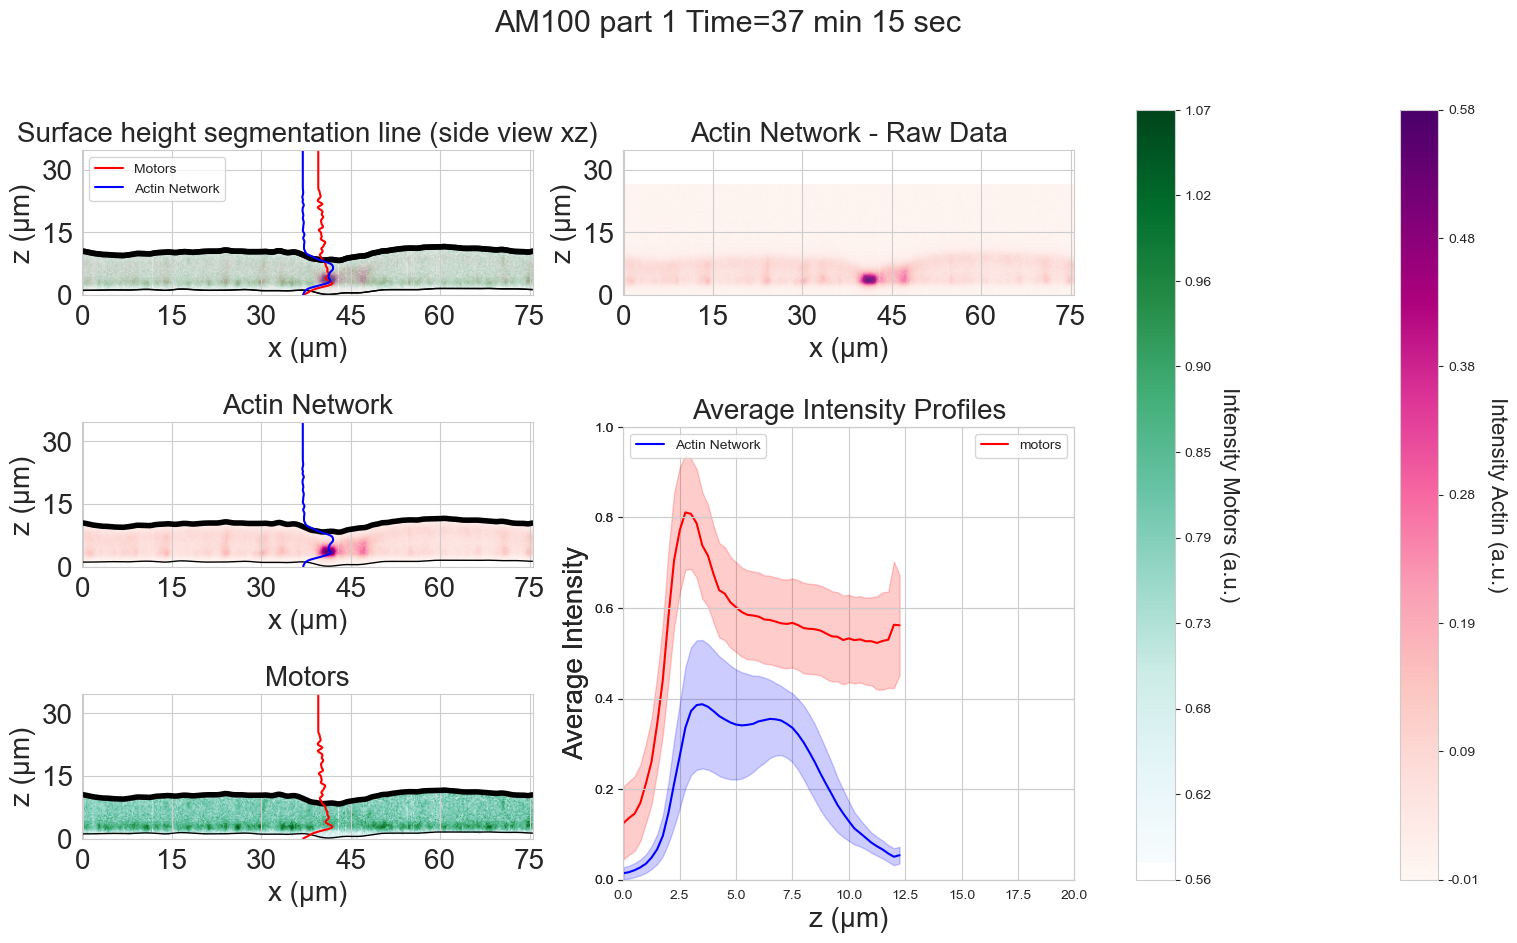

In [8]:
# Animation parameters
pixel_size_x = 0.175 
pixel_size_z = 0.250
vmin = 0.8
vmax = 2
vmin_membrane = 0.98
vmax_membrane = 1.2
z1 = 0
z2 = gel.shape[1]
y = 100
plot_sigma = 3
color_map = 'RdPu'
color_map_membrane = 'BuGn'    
alpha_membrane = 0.4
alpha_gel = 0.9
x0_mem = 210
x0 = 210
movie_name = 'AM100 part 1'
channel_2_label = 'Motors' #'SLB'
membrane_plot_sigma = 7
draw_segmentation_line = True
plot_line_scan_gel = True
plot_line_scan_membrane = True
cut_membrane_to_the_top = False
save_images = True
# --- frames replaced with spike 19-24
frames_per_sec = 4
#t_values = np.concatenate((np.arange(0,  19,1/frames_per_sec),np.arange(20,  28,1/frames_per_sec), np.arange(30,len(gel),1/frames_per_sec)), axis = 0)  # Replace start_t and end_t with your desired range
t_values= np.arange(0, len(gel), 1/frames_per_sec)
gel_shape_1 = 80 # this is the maximum z that will be shown in the distribution plot, this is different from the side view, that can show the gel + blank space


# Create the figure and axis

norm = Normalize(vmin=vmin, vmax=vmax)
fig, axes  = plt.subplots(3, 2, figsize=(20, 10))
for ax in axes.ravel():
    ax.grid(True)
(ax1,ax2, ax3) = axes[:,0]
(ax4,ax5, ax6) = axes[:,1]
fig.delaxes(ax6)
twin_ax5 = ax5.twinx()
pos_ax5 = ax5.get_position()  # Get the original position of ax5
pos_ax6 = ax6.get_position()  # Get the original position of ax6
new_width = pos_ax6.x1 - pos_ax5.x0  # Calculate new width
ax5.set_position([pos_ax5.x0, pos_ax6.y0, new_width, pos_ax5.height + pos_ax6.height])  # Set new position
original_position_ax5 = ax5.get_position()
twin_ax5.set_position(original_position_ax5)

c2max = np.percentile(channel2[~np.isnan(channel2)], 99.8)
c2min = np.nanmin(channel2)
c1max = np.percentile(gel[~np.isnan(gel)], 99.8)
c1min = np.nanmin(gel)

mappable = ScalarMappable(norm=norm, cmap=color_map)
mappable.set_array(gel[:, :, y, :])

cbar = plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=1)
cbar.set_label('Intensity Actin (a.u.)', rotation=270, fontsize = 16, labelpad = 20)
current_ticks = cbar.get_ticks()
new_labels = [f"{(tick - c1min)/(c1max-c1min):.2f}" for tick in current_ticks]
cbar.set_ticks(current_ticks)
cbar.set_ticklabels(new_labels)


norm_ch2 = Normalize(vmin=vmin_membrane, vmax=vmax_membrane)
mappable_ch2 = ScalarMappable(norm=norm_ch2, cmap=color_map_membrane)
mappable_ch2.set_array(channel2[:, :, y, :])

cbar_ch2 = plt.colorbar(mappable_ch2, ax=axes.ravel().tolist(), shrink=1)
cbar_ch2.set_label('Intensity Motors (a.u.)', rotation=270, fontsize = 16, labelpad = 20)
current_ticks = cbar_ch2.get_ticks()
new_labels = [f"{(tick - c2min)/(c2max-c2min):.2f}" for tick in current_ticks]
cbar_ch2.set_ticks(current_ticks)
cbar_ch2.set_ticklabels(new_labels)

dist_df_motors = pd.read_csv(DATA_PATH + '%s/np/%s_%s_dist.csv'%(movie, movie, 'motors_norm'))
dist_df_gel = pd.read_csv(DATA_PATH + '%s/np/%s_%s_dist.csv'%(movie, movie,'gel_norm'))
y_distribution_max = np.nanmax(dist_df_gel['normalized intensity z mean'].values
                               + dist_df_motors['normalized intensity z mean'].values)
y_distribution_max =1

# Create a function to update the plot for each t value
def update(t):
    if ~(t == int(t)):
        return
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    twin_ax5.clear()
    t = int(t)
    plot_segmented_view(ax1, gel, surface, t, pixel_size_x, pixel_size_z, vmin,vmax, color_map,y,alpha_gel)
    plot_segmented_view(ax1, channel2, surface, t, pixel_size_x, pixel_size_z, vmin_membrane,vmax_membrane, color_map_membrane,y,alpha_membrane)
    #   Raw Data  image ax2
 

    ax1.set_title('Surface height segmentation line (side view xz)', fontsize = 20)
   
# ---------------- plot membrane and gel intensity line scan
  
      
    if plot_line_scan_membrane:
        
        plot_line_scan(ax1, channel2, t, y, x0_mem, channel_2_label, line_scan_color = 'red')
    if plot_line_scan_gel:
        plot_line_scan(ax1, gel, t, y, x0,  'Actin Network', line_scan_color = 'blue')
    if plot_line_scan_membrane and plot_line_scan_gel:
        ax1.legend(loc = 'upper left')
    
    
    plot_segmented_view(ax2, gel, surface, t, pixel_size_x, pixel_size_z, vmin,vmax, color_map,y,1, draw_segmentation_line = True)
    plot_line_scan(ax2, gel, t, y, x0,  'Actin Network', line_scan_color = 'blue')
    ax2.set_title('Actin Network', fontsize = 20)
    plot_segmented_view(ax3, channel2, surface, t, pixel_size_x, pixel_size_z, vmin_membrane,vmax_membrane, color_map_membrane,y,1 , draw_segmentation_line = True)
    plot_line_scan(ax3, channel2, t, y, x0_mem, channel_2_label, line_scan_color = 'red')
    ax3.set_title('Motors', fontsize = 20)
    #----------------- Right image raw data  ax4

    plot_segmented_view(ax4, gel, surface, t, pixel_size_x, pixel_size_z, vmin,vmax, color_map,y,alpha_gel, draw_segmentation_line = False, nans_outside_gel=False)
   
    ax4.set_title('Actin Network - Raw Data', fontsize = 20)
   
    mean = dist_df_motors[dist_df_motors['time'] == t]['normalized intensity z mean'].values
    std = dist_df_motors[dist_df_motors['time'] == t]['normalized intensity z std'].values
    z = dist_df_motors[dist_df_motors['time'] == t]['z'].values
    plot_distribution(ax5, z, pixel_size_z, gel_shape_1, mean, std , y_distribution_max,'motors', channel_color='red')

    mean = dist_df_gel[dist_df_gel['time'] == t]['normalized intensity z mean'].values
    std = dist_df_gel[dist_df_gel['time'] == t]['normalized intensity z std'].values
    z = dist_df_gel[dist_df_gel['time'] == t]['z'].values

    plot_distribution(twin_ax5, z, pixel_size_z, gel_shape_1, mean, std, y_distribution_max, 'Actin Network', channel_color = 'blue')
   
    ax5.legend(loc = 'upper right')
    twin_ax5.legend(loc = 'upper left')
    ax5.set_title('Average Intensity Profiles', fontsize = 20)
    #  ----------------------- Title --------------------------------------------------------------
    frame_time = int(time_df.loc[time_df['frame'] == t, 'time (sec)'].values[0])
    fig.suptitle('%s Time=%s ' % (movie_name,gu.time_string(frame_time)), fontsize = 22, x = 0.45)
    if save_images:
        plt.savefig(GRAPH_PATH + 'sideview/images_%s/%s_side_%s_time_%d.png'%(movie, movie, color_map, t), dpi=300, bbox_inches='tight')

# Create the animation
animation = FuncAnimation(fig, update, frames=t_values, repeat=False, interval=1000)  # 1 second per frame

# Save the animation as an MPEG file
animation.save(GRAPH_PATH + 'sideview/%s_side_seg_line=%s_mem_%s_%s.avi'%(movie, draw_segmentation_line, plot_line_scan_membrane,color_map), writer='ffmpeg', extra_args=['-crf', '8'], codec = 'h264', fps=4)

# Display the animation (optional)
plt.show()


## <span color='red'>plot gel and motors intensity and distribution </span  >   

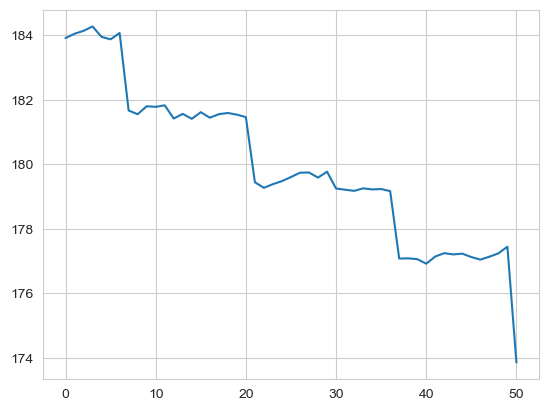

In [141]:
# Animation parameters
pixel_size_x = 0.175
pixel_size_z = 0.250
vmin = 0.8
vmax = 2
vmin_membrane = 180
vmax_membrane = 220
z1 = 0
z2 = gel.shape[1]
y = 100
plot_sigma = 3
color_map = 'RdPu'
color_map_membrane = 'Oranges'
alpha_membrane = 0.4
alpha_gel = 0.9
movie_name = 'AM100 part 3'
channel_2_label = 'Motors' #'SLB'
membrane_plot_sigma = 7
draw_segmentation_line = True
plot_line_scan_gel = True
plot_line_scan_membrane = True
cut_membrane_to_the_top = False
save_images = True
# --- frames replaced with spike 19-24
frames_per_sec = 4
#t_values = np.concatenate((np.arange(0,  19,1/frames_per_sec),np.arange(20,  28,1/frames_per_sec), np.arange(30,len(gel),1/frames_per_sec)), axis = 0)  # Replace start_t and end_t with your desired range
t_values= np.arange(0, len(gel), 1/frames_per_sec)
mu_symbol = "\u03BC"


# Create the figure and axis

norm = Normalize(vmin=vmin, vmax=vmax)
fig, axes  = plt.subplots(1, 2, figsize=(20, 3))
(ax1,ax2) = axes
mappable = ScalarMappable(norm=norm, cmap=color_map)
mappable.set_array(gel[:, :, y, :])

cbar = plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=1)
cbar.set_label('Intensity Actin (a.u.)', rotation=270, fontsize = 16, labelpad = 20)

norm_ch2 = Normalize(vmin=vmin_membrane, vmax=vmax_membrane)
mappable_ch2 = ScalarMappable(norm=norm_ch2, cmap=color_map_membrane)
mappable_ch2.set_array(channel2[:, :, y, :])

cbar_ch2 = plt.colorbar(mappable_ch2, ax=axes.ravel().tolist(), shrink=1)
cbar_ch2.set_label('Intensity Motors (a.u.)', rotation=270, fontsize = 16, labelpad = 20)


def update(t):
    frame_time = int(time_df.loc[time_df['frame'] == t, 'time (sec)'].values[0])
    ax1.clear()
    h = surface[t]
    img = gel[t, z1:z2, y, x1:x2].copy()  #+ mem_intensity[t,z1:z2,y,x1:x2].copy()
    img_mem = channel2[t, z1:z2, y, x1:x2].copy()
    img_mem[np.isnan(img_mem)] = 0

    ax1.imshow(img, origin='lower', cmap='RdPu', alpha=0.6)  #, vmin= 1.11, vmax =3.5)#,extent=extent)
    ax1.imshow(img_mem, origin='lower', cmap='Greys', alpha=0.4)  #, vmin= 1.11, vmax =3.5)#,extent=extent)

    ax1.grid(True)
    ax1.set_xlabel('X (Pixels)')
    ax1.set_ylabel('Z (Pixels)')
    im = ax1.plot(gaussian_filter(h[y, x1:x2], sigma=plot_sigma), 'black', lw=4, linestyle='-')
    x0 = 100
    x0_mem = 100
    line = my_normalize(gu.interpolate_smooth_restore_1d(gel[t, z1:z2, y, x0], 5))
    line_no_nan = line[~np.isnan(line)]
    last_value = line_no_nan[-1]
    line[np.isnan(line)] = last_value

    ax1.plot(line * 25 + x0, np.arange(z1, z2), 'blue', label='Gel')
    line_mem = my_normalize(gaussian_filter(channel2[t, z1:z2, y, x0], 5))
    line_mem_no_nan = line_mem[~np.isnan(line_mem)]
    last_value = line_mem_no_nan[-1]
    line_mem[np.isnan(line_mem)] = last_value

    ax1.plot(line_mem * 10 + x0_mem, np.arange(z1, z2), 'red', label='motors')
    ax1.legend()
    fig.suptitle('Time=%s ' % gu.time_string(frame_time))

    ax1.set_xlabel('X (mu)')
    ax1.set_xticks(np.arange(0, img.shape[1], 50), (np.arange(0, img.shape[1], 50) * pixel_size_x).astype(int))
    ax1.set_ylabel('Z (mu)')
    ax1.set_yticks(np.arange(0, img.shape[0], 10), (np.arange(0, img.shape[0], 10) * pixel_size_z).astype(int))
    # ----------------- distribution ax2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        gel_dist = np.nanmean(gel[t, z1:z2, y, x1:x2], axis=1)
        gel_std = np.nanstd(gel[t, z1:z2, y, x1:x2], axis=1)
        motors_dist = np.nanmean(channel2[t, z1:z2, y, x1:x2], axis=1)
        motors_std = np.nanstd(channel2[t, z1:z2, y, x1:x2], axis=1)
    ax2.clear()
    ax2.plot(gel_dist, 'blue', label='Gel')
    ax2.fill_between(np.arange(z1, z2), gel_dist - gel_std, gel_dist + gel_std, alpha=0.2)
    ax2.plot(motors_dist, 'red', label='motors')
    ax2.fill_between(np.arange(z1, z2), motors_dist - motors_std, motors_dist + motors_std, alpha=0.2)
    ax2.legend()
    ax2.set_xlabel('Z')
    ax2.set_ylabel('Intensity')
    ax2.set_title('Distribution')
    ax2.set_ylim(0, y_distribution_max)


# Create the figure and axis

# Create the animation
animation = FuncAnimation(fig, update, frames=t_values, repeat=False, interval=1000)  # 1 second per frame

# Save the animation as an MPEG file
animation.save(GRAPH_PATH + 'sideview/%s_dist.avi' % movie, writer='ffmpeg', dpi=300, codec='h264')

# Display the animation (optional)
plt.show()

plt.plot(np.nanmean(channel2[:, :, 200, :], axis=(1, 2)))
plt.show()

In [112]:
import importlib
importlib.reload(utils.graph_utils)

<module 'utils.graph_utils' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\utils\\graph_utils.py'>

In [14]:
# reload graph_utils
importlib.reload(utils.graph_utils)


<module 'utils.graph_utils' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\utils\\graph_utils.py'>

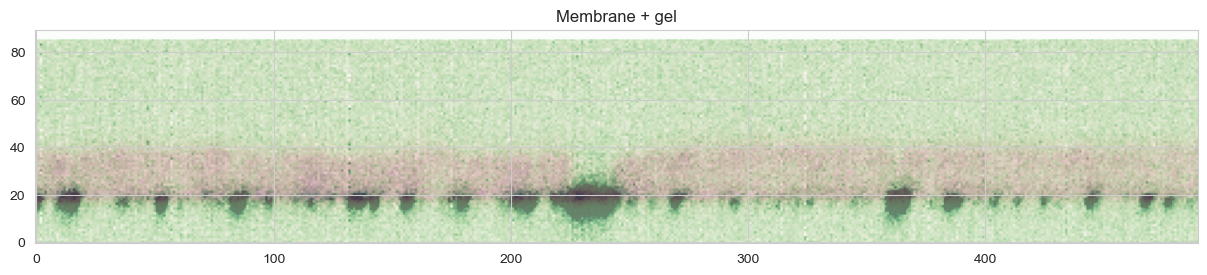

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(img,origin='lower', cmap='RdPu', alpha=0.8)#, vmin= 1.11, vmax =3.5)#,extent=extent)

ax.imshow((img_mem-100)/50,origin='lower', cmap='Greens', alpha=0.6, vmin= -0.2, vmax =0.5)#,extent=extent)
ax.set_title('Membrane + gel')
plt.show()



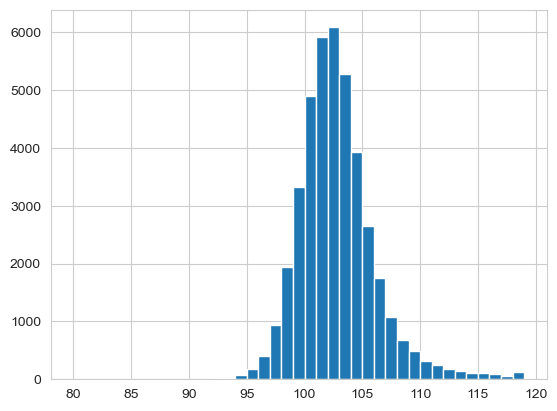

In [38]:
plt.hist(img_mem.flatten(), bins = range(80,120))
plt.show()


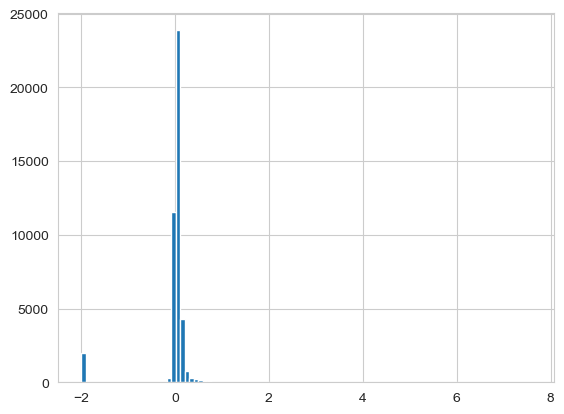

In [40]:
plt.hist(((img_mem-100)/50).flatten(), bins = 100)
plt.show()

In [38]:
print(np.nanmin(img), np.nanmax(img))

0.8590969244748746 3.466340160954446


## <span color='red'> TOP VIEW

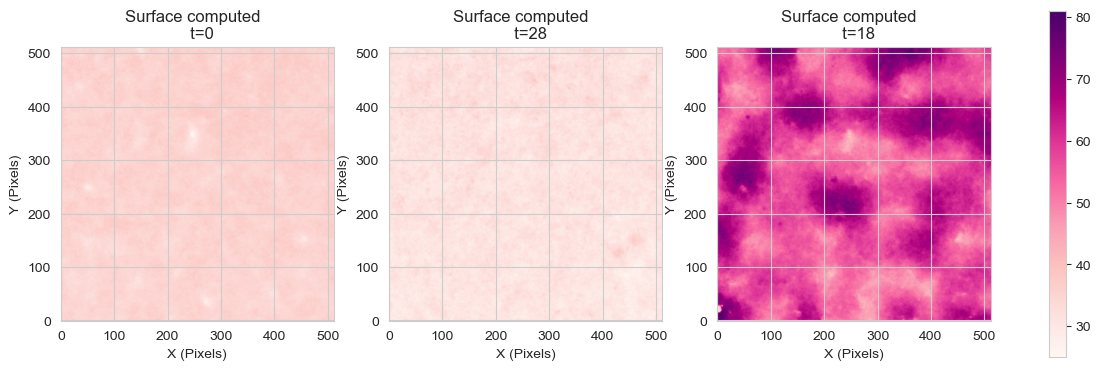

In [45]:

T =[0,28,18]

vmin = np.nanmin([np.nanmin(surface[t]) for t in T])
vmax = np.nanmax([np.nanmax(surface[t]) for t in T])
fig, axes = plt.subplots(1,3,figsize=(15,15))

for i,t in enumerate(T):
    im= axes[i].imshow(surface[t], origin='lower', cmap='RdPu', vmax = vmax, vmin = vmin )
    #ax2.hlines(y=y, xmin=0, xmax=h.shape[0], color='b')

    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface computed  \n  t=%d'%(t))
    
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)

        
    # Show the plot
plt.show()


## <span color='red'> TOP VIEW  Animtation

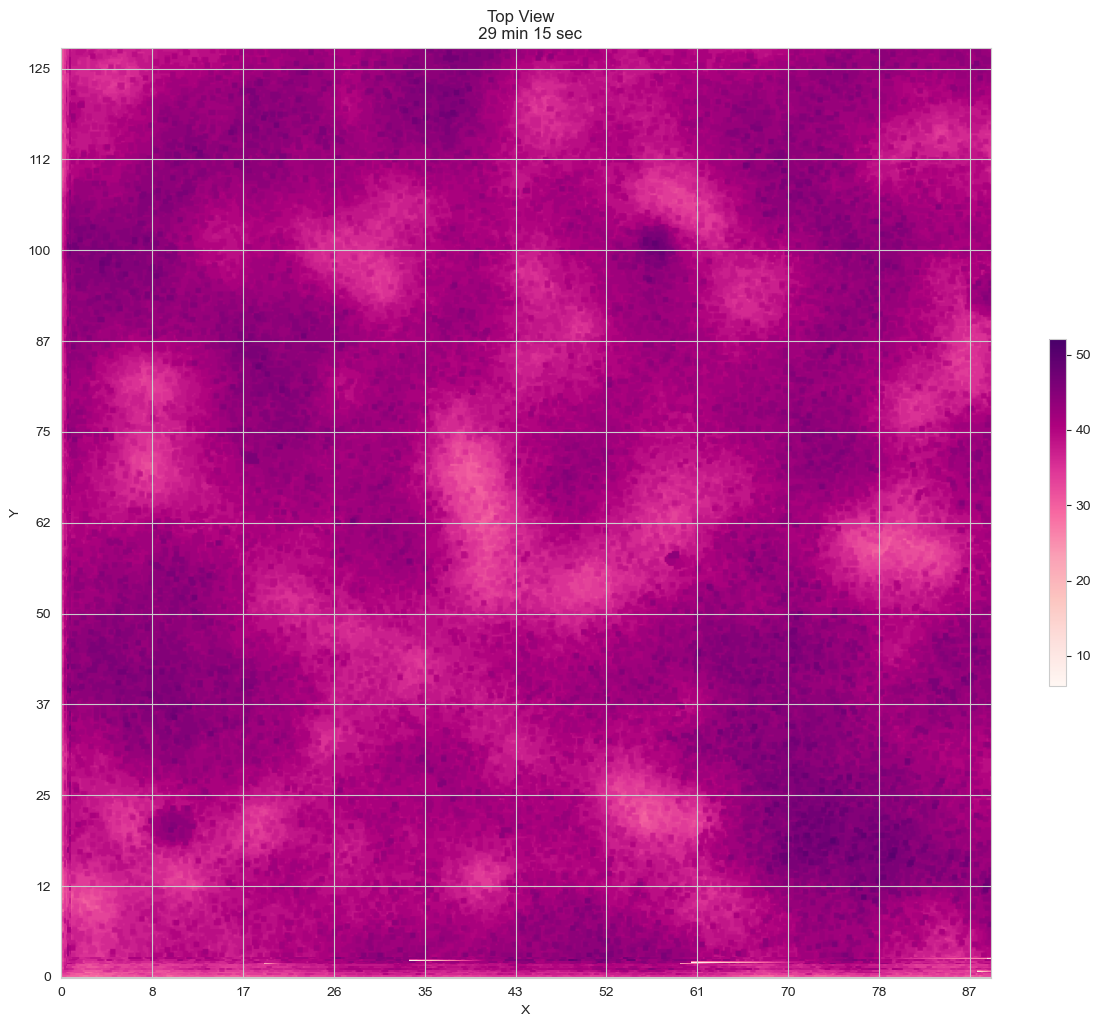

In [55]:

vmin = np.nanmin(surface)
vmax = np.nanmax(surface)
fig, ax = plt.subplots(1,1,figsize=(15,15))

def update(t):
    im= ax.imshow(surface[t], origin='lower', cmap='RdPu', vmax = vmax, vmin = vmin )
    frame_time = int(time_df.loc[time_df['frame'] == t, 'time (sec)'].values[0])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xticks(np.arange(0, surface.shape[1], 50), (np.arange(0, surface.shape[1], 50) * pixel_size_x).astype(int))
    ax.set_yticks(np.arange(0, surface.shape[2], 50), (np.arange(0, surface.shape[2], 50) * pixel_size_z).astype(int))
    ax.set_title('Top View  \n  %s'%(gu.time_string(frame_time)))

# create colorbar
norm = Normalize(vmin=vmin, vmax=vmax)
mappable = ScalarMappable(norm=norm, cmap=plt.cm.RdPu)
mappable.set_array(surface)  # Set the data array
plt.colorbar(mappable, ax=ax, shrink=0.3)


animation = FuncAnimation(fig, update, frames=range(len(surface)), repeat=False, interval=1000)  # 1 second per frame

# Save the animation as an MPEG file
animation.save(GRAPH_PATH + 'sideview/%s_topview.mp4'%movie, writer='ffmpeg', dpi=300)

# Show the plot
plt.show()

## <span color='red'> Intensity top view

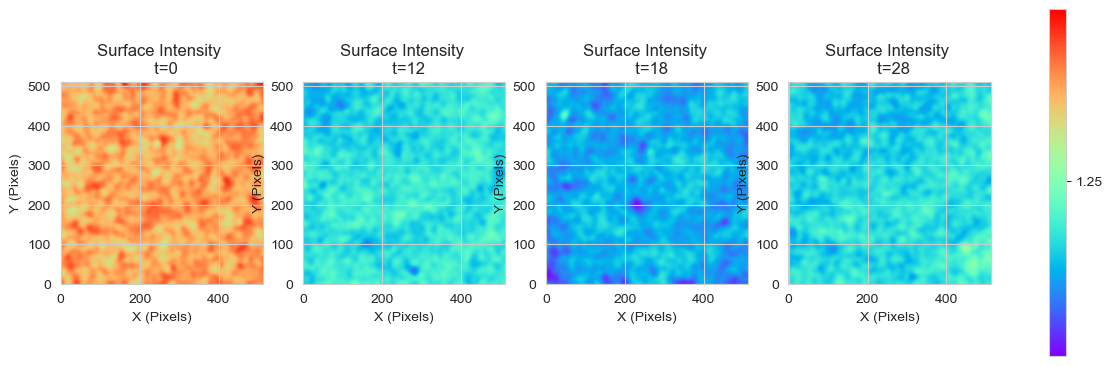

In [39]:
T =[0,12,18,28]

data = graph_utils.values_3d(gel, surface)
for t in T:
    data[t] = gaussian_filter(data[t],sigma =7)
vmin = np.nanmin([np.nanmin(data[t]) for t in T])
vmax = np.nanmax([np.nanmax(data[t]) for t in T])
fig, axes = plt.subplots(1,4,figsize=(15,15))
norm = Normalize(vmin=vmin, vmax=vmax)
for i,t in enumerate(T):
    im= axes[i].imshow(data[t], origin='lower', cmap='rainbow', vmax = vmax, vmin = vmin )
    #ax2.hlines(y=y, xmin=0, xmax=h.shape[0], color='b')

    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface Intensity \n  t=%d'%(t))

mappable = ScalarMappable(norm=norm, cmap=plt.cm.rainbow)
mappable.set_array(data[T])  # Set the data array
plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3, ticks = [1,1.25,1.5,1.75,2])

#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)

        
    # Show the plot
plt.show()


## <span color='red'> Intensity on surface membrane and motors

# preparation for geting values of intensity on membrane and surface

In [48]:
channel_name= ['Gel', 'Motors']
manifold_name = ['Membrane', 'Surface']
channel = 0
manifold = 0
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
surface = np.load(MOVIE_PATH + 'np/height.npy')
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')
membrane_mask = ~np.isnan(membrane)
surface_mask = ~np.isnan(surface)

membrane[np.isnan(membrane)] = 0
surface[np.isnan(surface)] = 0
membrane = membrane.astype(int)
surface = surface.astype(int)



# 3d plot of surface and membrane intensity motors and gels

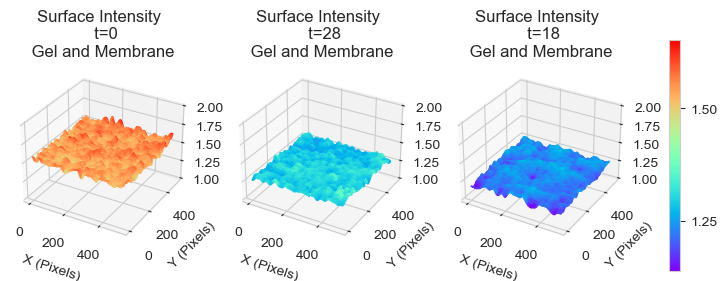

In [51]:
import numpy as np
import matplotlib.pyplot as plt
T =[0,28,18]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)

# Create random 3D array with dimensions (time, x, y)

for m_index, manifold in enumerate([surface-2]):#membrane+3, 
    for e_index ,experiment_data in enumerate([gel]):
        
        data = graph_utils.values_3d(experiment_data, manifold)
        #data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
        vmin = np.nanmin([np.nanmin(gaussian_filter(data[t],sigma =7)) for t in T])
        vmax = np.nanmax([np.nanmax(gaussian_filter(data[t],sigma =7)) for t in T])

        label = channel_name[e_index] + ' and ' + manifold_name[m_index ]

        # Initialize the plot
        fig, axes = plt.subplots(1,len(T), figsize=(10, 10), subplot_kw={'projection': '3d'})

        norm = Normalize(vmin=vmin, vmax=vmax)
        for i,t in enumerate(T):
            Z = gaussian_filter(data[t],sigma =7)
            
            colors = plt.cm.rainbow(norm(Z))
            axes[i].set_xlabel('X (Pixels)')
            axes[i].set_ylabel('Y (Pixels)')
            axes[i].set_title('Surface Intensity \n  t=%d\n %s'%(t,label))
            im = axes[i].plot_surface(X,Y,Z,  facecolors=colors, shade=False)#, vmin= vmin, vmax =vmax)
            axes[i].set_zlim(1, 2)
        #plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
        #plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
        mappable = ScalarMappable(norm=norm, cmap=plt.cm.rainbow)
        mappable.set_array(data[T])  # Set the data array

        # Now, create the colorbar
        plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3, ticks = [1,1.25,1.5,1.75,2])

        plt.show()


# stat data

In [ ]:
#  ------- too complex 

monomoer_mean = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_mean']
monomer_std = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_std']

manifold_width_range = [0]
for m_index, manifold in enumerate([membrane,surface]): 
    for e_index ,experiment_data in enumerate([gel]):
        mean_list = []
        std_list = []
        data = graph_utils.values_3d(experiment_data, manifold)
        for t in range(0- manifold_width_range[0],len(experiment_data) - manifold_width_range[-1]):
            mean_list.append(np.nanmean([data[t + offset] for offset in manifold_width_range]))
            std_list.append(np.nanstd([data[t + offset] for offset in manifold_width_range]))
        plt.scatter(range(len(mean_list)),mean_list, label = channel_name[e_index] + ' + monomer on  ' + manifold_name[m_index ])
      

        plt.fill_between(np.arange(len(mean_list)), np.array(mean_list) - np.array(std_list), np.array(mean_list) + np.array(std_list), alpha=0.2)
    plt.scatter(range(len(mean_list)),monomer_mean, label = 'monomer mean intensity')
    plt.fill_between(np.arange(len(mean_list)), monomer_mean - monomer_std, monomer_mean + monomer_std, alpha=0.2)
plt.legend()
plt.title('Mean and std of intensity on manifold \n Movie = %s'%movie)
plt.show()

          

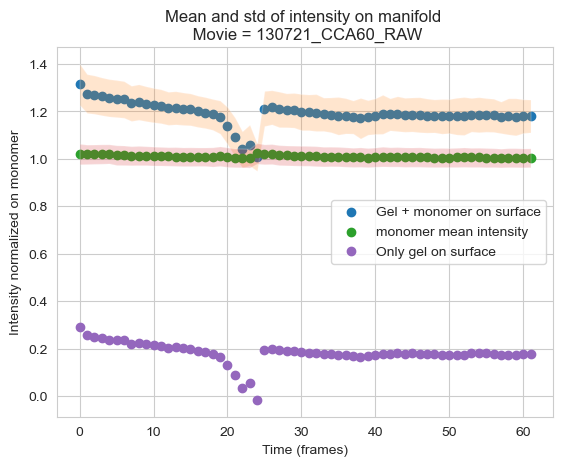

In [19]:
monomoer_mean = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_mean']
monomer_std = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_std']

manifold_width_range = [0]
manifold = surface
experiment_data = gel
mean_list = []
std_list = []
data = graph_utils.values_3d(experiment_data, manifold)
for t in range(0- manifold_width_range[0],len(experiment_data) - manifold_width_range[-1]):
    mean_list.append(np.nanmean([data[t + offset] for offset in manifold_width_range]))
    std_list.append(np.nanstd([data[t + offset] for offset in manifold_width_range]))
plt.scatter(range(len(mean_list)),mean_list, label =  'Gel + monomer on surface')
plt.fill_between(np.arange(len(mean_list)), np.array(mean_list) - np.array(std_list), np.array(mean_list) + np.array(std_list), alpha=0.2)
plt.scatter(range(len(mean_list)),monomer_mean, label = 'monomer mean intensity')
plt.fill_between(np.arange(len(mean_list)), monomer_mean - monomer_std, monomer_mean + monomer_std, alpha=0.2)
plt.scatter(range(len(mean_list)),mean_list - monomer_mean, label = 'Only gel on surface')
plt.legend()
plt.title('Mean and std of intensity on manifold \n Movie = %s'%movie)
plt.xlabel('Time (frames)')
plt.ylabel('Intensity normalized on monomer')
plt.show()

In [16]:
#reload graph_utils
importlib.reload(utils.graph_utils)   

<module 'utils.graph_utils' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\utils\\graph_utils.py'>

## <span color='red'> 3d plot of surface height

# surface plot

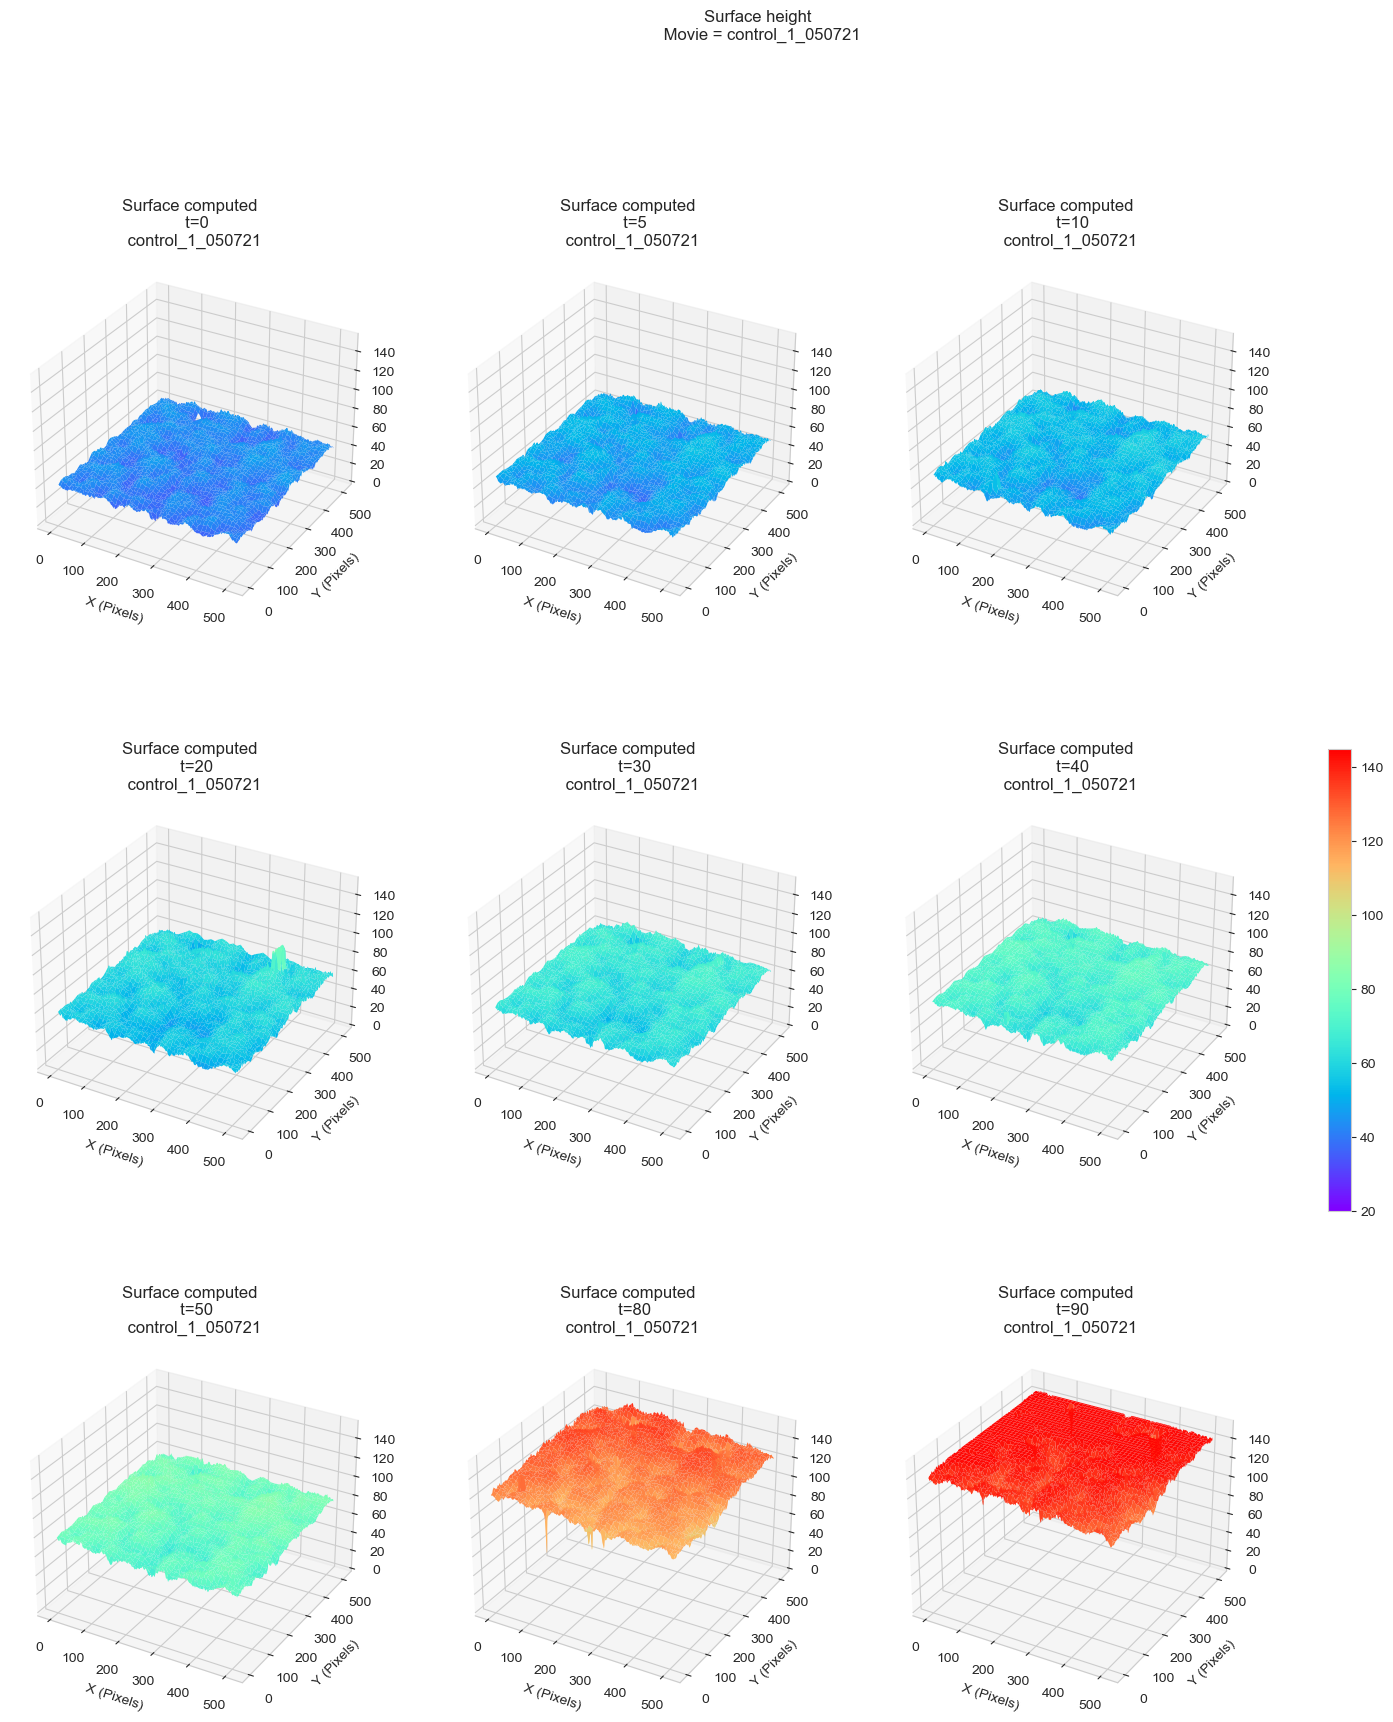

In [25]:
T =[0,5,10,20,30,40,50,80,90]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)
sigma =1 # smoothing of the height
# Create random 3D array with dimensions (time, x, y)

data = surface
#data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
v_min = np.min([np.nanmin(data[t]) for t in T])
v_max = np.max([np.nanmax(data[t]) for t in T])

# Initialize the plot
fig, axes = plt.subplots(3, 3, figsize=(20, 20), subplot_kw={'projection': '3d'})

norm = Normalize(vmin=v_min, vmax=v_max)
#colors = plt.cm.viridis(norm(data[T]))

for i,t in enumerate(T):
    Z = gaussian_filter(data[t],sigma =sigma)
    axes[i//3,i%3].set_xlabel('X (Pixels)')
    axes[i//3,i%3].set_ylabel('Y (Pixels)')
    axes[i//3,i%3].set_title('Surface computed \n  t=%d\n %s'%(t,movie))
    im = axes[i//3,i%3].plot_surface(X,Y,Z, cmap='rainbow', norm=norm,  alpha =1, linewidth = 0)#, vmin= vmin, vmax =vmax)
    #im.set_clim(v_min, v_max)
    axes[i//3,i%3].set_zlim(0, v_max+10)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
mappable = ScalarMappable(norm=norm, cmap= 'rainbow'  )
#mappable.set_array(data[T])  # Set the data array

# Now, create the colorbar
plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3)
plt.suptitle('Surface height \n Movie = %s'%movie)
plt.show()


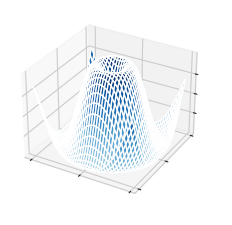

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

plt.style.use('_mpl-gallery')

# Make data
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.savefig(MOVIE_PATH + "tmp/surface.png", dpi=300)

plt.show()

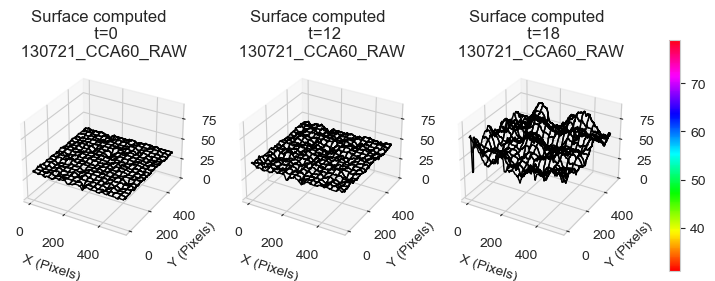

In [31]:
T =[0,12,18]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)
sigma =1 # smoothing of the height
# Create random 3D array with dimensions (time, x, y)

data = surface
#data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
vmin = np.nanmin([np.nanmin(data[t]) for t in T])
vmax = np.nanmax([np.nanmax(data[t]) for t in T])

# Initialize the plot
fig, axes = plt.subplots(1,len(T), figsize=(10, 10), subplot_kw={'projection': '3d'})


for i,t in enumerate(T):
    Z = gaussian_filter(data[t],sigma =sigma)
    norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
    colors = plt.cm.hsv(norm(Z))
    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface computed \n  t=%d\n %s'%(t,movie))
    im = axes[i].plot_surface(X, Y, Z, rstride=30, cstride=30, facecolors=None, edgecolor='k', shade=False, alpha = 0)
    axes[i].set_zlim(0, vmax+10)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
mappable = ScalarMappable(norm=norm, cmap=plt.cm.hsv)
mappable.set_array(data[T])  # Set the data array

# Now, create the colorbar
plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3)

plt.show()


In [101]:
plt.savefig(r'\\132.72.218.248\Yuval_and_Shachar\evolution paper\\' + '%s_sideview_t%dy%d+membrane.png'%(movie,t,y))#, bbox_inches=extent)
plt.show()



<Figure size 640x480 with 0 Axes>

## <span color='red'> SAVE STATISTICS

In [9]:
from analysis import exploration_exec as ex
import os
movie_list = ['130721_CCA60_RAW',
'control_1_050721', 'cca120','cca120_am200','280523 AM100 568_1','280523 AM100 568_2','280523 AM100 568_3']
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
os.path.join(PROJECT_PATH, "add_data/", movie + "/")

for movie in movie_list:
    stat_df = ex.surface_stat_save(movie)
    stat_df.columns = stat_df.columns.map(lambda x: 'surface_height_' + str(x))

    mono_df = pd.read_csv(os.path.join(PROJECT_PATH, "add_data/" , movie) + '/monomer_rect.csv')
    stat_df['monomer_fitted_mean'] = mono_df['gaussian_mean']
    stat_df['monomer_fitted_std'] = mono_df['gaussian_std']
    stat_df.to_csv(DATA_PATH + 'all/%s_surface_stat.csv'%movie)

In [56]:
importlib.reload(ex)


<module 'analysis.exploration_exec' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\analysis\\exploration_exec.py'>

In [123]:
from analysis import exploration_exec as ex
import os
movie_list = ['130721_CCA60_RAW',
              'control_1_050721', 'cca120','cca120_am200','280523 AM100 568_1','280523 AM100 568_2','280523 AM100 568_3']
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
os.path.join(PROJECT_PATH, "add_data/", movie + "/")
channel_list = ['gel_norm', 'motors_norm']
for movie in tqdm(movie_list[-3:-2]):
    for channel in channel_list:
         stat_df = ex.surface_distribution_save(movie, channel= channel)
         stat_df.to_csv(DATA_PATH + '%s/np/%s_%s_dist.csv'%(movie, movie,channel), index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
channel_list = ['gel_norm', 'motors_norm']


In [124]:
# ---- take the previous output and put in horizontal format
import os
movie_list = ['130721_CCA60_RAW',
              'control_1_050721', 'cca120','cca120_am200','280523 AM100 568_1','280523 AM100 568_2','280523 AM100 568_3']
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
os.path.join(PROJECT_PATH, "add_data/", movie + "/")
for movie in tqdm(movie_list[-3:-2]):
    for channel in channel_list:
        df = pd.DataFrame()
        norm_df = pd.DataFrame()
        stat_df = pd.read_csv(DATA_PATH + '%s/np/%s_%s_dist.csv'%(movie, movie,channel))
        for t in stat_df['time'].unique():
            tmp_df = stat_df[stat_df['time'] == t][['z', 'intensity z mean', 'intensity z std']]
            tmp_df_norm = stat_df[stat_df['time'] == t][['z', 'normalized intensity z mean', 'normalized intensity z std']]
            tmp_df=tmp_df.reset_index(drop=True)
            tmp_df_norm=tmp_df_norm.reset_index(drop=True)
            
            #add t to column name
            tmp_df.columns = tmp_df.columns.map(lambda x: str(x) + '_' + str(t))
            tmp_df_norm.columns = tmp_df_norm.columns.map(lambda x: str(x) + '_' + str(t))
            df = df.reset_index(drop=True)
            norm_df = norm_df.reset_index(drop=True)
            df = pd.concat([df, tmp_df], axis = 1)
            norm_df = pd.concat([norm_df, tmp_df_norm], axis = 1)
        df.to_csv(DATA_PATH + 'all/%s_%s_distribution_horizontal.csv'%(movie,channel))
        norm_df.to_csv(DATA_PATH + 'all/%s_%s_distribution_horizontal_norm.csv'%(movie,channel))


  0%|          | 0/1 [00:00<?, ?it/s]

<span color='red'>  z value of max distribution </span  >

In [9]:

movie_list = ['130721_CCA60_RAW',
              'control_1_050721', 'cca120','cca120_am200','280523 AM100 568_1','280523 AM100 568_2','280523 AM100 568_3']
channel_list = ['gel_norm', 'motors']

PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
os.path.join(PROJECT_PATH, "add_data/", movie + "/")
for movie in tqdm(movie_list[-3:]):
    for channel in channel_list[-1:]:
        max_intensity_arg = []
        t_list = []
        max_intensity_list = []
        df = pd.DataFrame()
        stat_df = pd.read_csv(DATA_PATH + '%s/np/%s_%s_dist.csv'%(movie, movie,channel))
        for t in stat_df['time'].unique():
            max_intensity_arg.append(np.nanargmax(stat_df[stat_df['time'] == t]['normalized intensity z mean'].values))
            t_list.append(t)
            max_intensity_list.append(np.nanmax(stat_df[stat_df['time'] == t]['normalized intensity z mean'].values))
        df['%s_%s_t'%(movie,channel)] = t_list
        df['%s_%s_z'%(movie,channel)] = max_intensity_arg
        df['%s_%s_max'%(movie,channel)] = max_intensity_list
        df.to_csv(DATA_PATH + 'all/%s_%s_max_distribution.csv'%(movie,channel))

  0%|          | 0/3 [00:00<?, ?it/s]

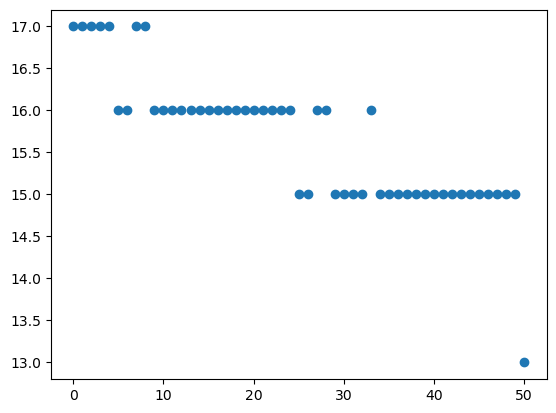

In [64]:
plt.scatter(t_list, max_intensity_arg)
#plt.ylim(35,45)
plt.show()